In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from LearningAlgorithms import ClassificationAlgorithms
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

In [26]:
# --------------------------------------------------------------
# Plot settings
# --------------------------------------------------------------

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [27]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------

df = pd.read_pickle("../../data/interim/03_data_features.pkl")

print(df.head())

                            acc_x     acc_y     acc_z      gyr_x      gyr_y  \
epoch (ms)                                                                    
2019-01-11 15:08:08.000 -0.170494  0.888970 -0.172353 -25.990313 -10.162423   
2019-01-11 15:08:08.400 -0.027634  0.878027 -0.056321  -4.311919  -1.963210   
2019-01-11 15:08:08.800 -0.060139  0.982341 -0.036019   3.691356  -1.273743   
2019-01-11 15:08:09.200 -0.048152  0.984179 -0.036625  -0.251944  -3.967927   
2019-01-11 15:08:09.600 -0.043981  0.900329 -0.056932  11.319237   5.163204   

                             gyr_z participant  label category  set  ...  \
epoch (ms)                                                           ...   
2019-01-11 15:08:08.000  25.426906           B  bench    heavy   30  ...   
2019-01-11 15:08:08.400   3.088785           B  bench    heavy   30  ...   
2019-01-11 15:08:08.800  -2.492890           B  bench    heavy   30  ...   
2019-01-11 15:08:09.200   4.930061           B  bench    heavy   3

Number of Train examples: 2901
Number of Test examples: 967


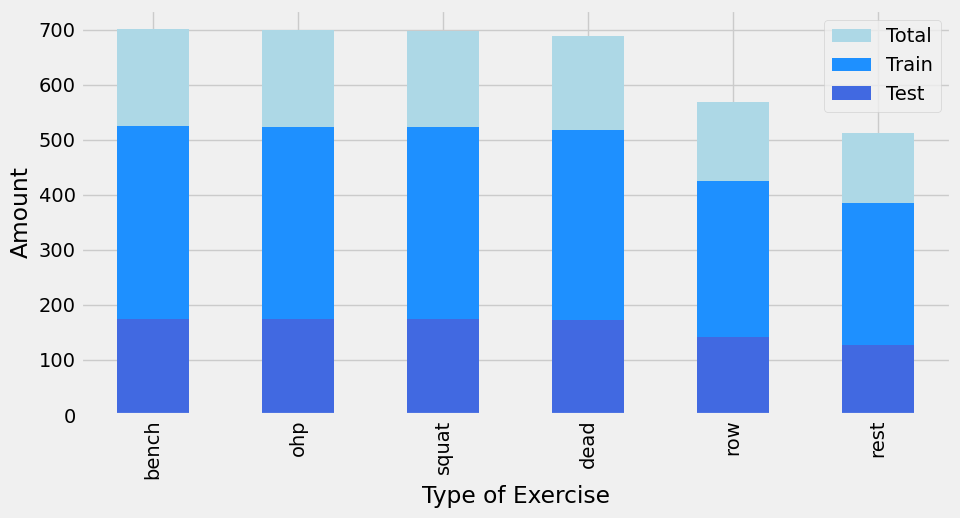

In [28]:
# --------------------------------------------------------------
# Create a training and test set
# --------------------------------------------------------------

df_train = df.drop(["participant", "category", "set"], axis = 1)

X = df_train.drop("label", axis = 1)
y = df_train["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Number of Train examples: {len(X_train)}")
print(f"Number of Test examples: {len(y_test)}")

fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().plot(kind="bar", ax=ax, color="lightblue", label="Total")
y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.xlabel("Type of Exercise")
plt.ylabel("Amount")
plt.legend()
plt.show()

In [29]:
# --------------------------------------------------------------
# Split feature subsets
# --------------------------------------------------------------

basic_features = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]
square_features = ["acc_r", "gyr_r"]
pca_features = ["pca_1", "pca_2", "pca_3"]
time_features = [f for f in df_train.columns if "_temp_" in f]
freq_features = [f for f in df_train.columns if (("_freq" in f) or ("_pse" in f))]
cluster_features = ["cluster"]

print(f"Basic Features: {len(basic_features)}")
print(f"Square Features: {len(square_features)}")
print(f"PCA Features: {len(pca_features)}")
print(f"Time Features: {len(time_features)}")
print(f"Frequency Features: {len(freq_features)}")
print(f"Cluster Features: {len(cluster_features)}")

feature_set_1 = list(set(basic_features))
feature_set_2 = list(set(feature_set_1 + square_features + pca_features))
feature_set_3 = list(set(feature_set_2 + time_features))
feature_set_4 = list(set(feature_set_3 + freq_features + cluster_features))

Basic Features: 6
Square Features: 2
PCA Features: 3
Time Features: 16
Frequency Features: 88
Cluster Features: 1


0
1
2
3
4
5
6
7
8
9
The result of Selected Features is: ['acc_z_freq_0.0_Hz_ws_14', 'acc_x_freq_0.0_Hz_ws_14', 'duration', 'gyr_r_temp_mean_ws_5', 'acc_y_max_freq', 'gyr_z_pse', 'gyr_y_freq_0.714_Hz_ws_14', 'acc_r_freq_weighted', 'acc_y_freq_2.5_Hz_ws_14', 'gyr_x_freq_2.143_Hz_ws_14']
The result of Ordered Scores is: [0.885556704584626, 0.9889693209238194, 0.9989658738366081, 0.9993105825577387, 0.9996552912788693, 1.0, 1.0, 1.0, 1.0, 1.0]


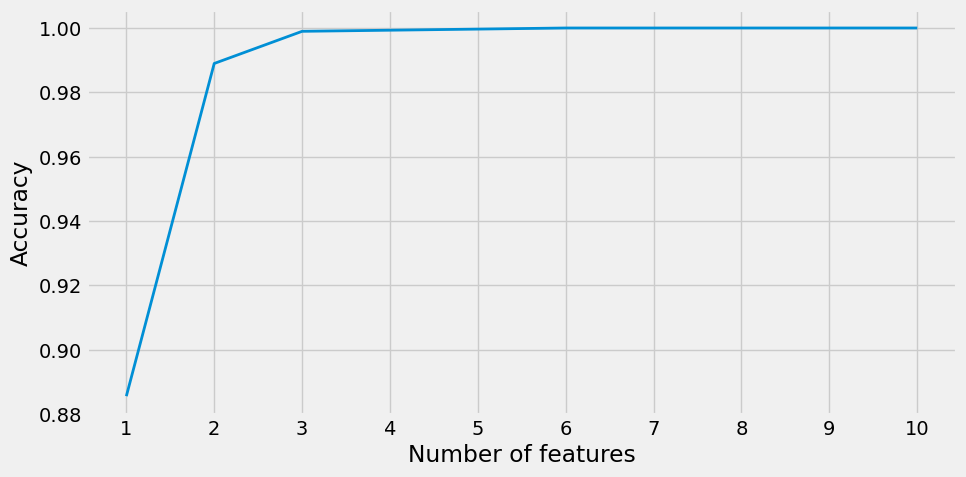

In [30]:
# --------------------------------------------------------------
# Perform forward feature selection using simple decision tree
# --------------------------------------------------------------

learner = ClassificationAlgorithms()

max_features = 10
selected_features, ordered_features, ordered_scores = learner.forward_selection(max_features, X_train, y_train)

print(f"The result of Selected Features is: {selected_features}")
print(f"The result of Ordered Scores is: {ordered_scores}")

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, max_features + 1, 1), ordered_scores)
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, max_features + 1, 1))
plt.show()

In [31]:
# --------------------------------------------------------------
# Grid search for best hyperparameters and model selection
# --------------------------------------------------------------

possible_feature_sets = [
  feature_set_1,
  feature_set_2,
  feature_set_3,
  feature_set_4,
  selected_features,
]

feature_names = [
  "Feature Set_1",
  "Feature Set_2",
  "Feature Set_3",
  "Feature Set_4",
  "Selected Features",
]

iterations = 1
score_df = pd.DataFrame()


for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


  model        feature_set  accuracy
1    RF      Feature Set_4  0.995863
1    RF  Selected Features  0.995863
3    DT  Selected Features  0.994829
0    NN      Feature Set_4  0.994829
0    NN  Selected Features  0.993795
3    DT      Feature Set_4  0.988625
0    NN      Feature Set_3  0.987590
1    RF      Feature Set_3  0.984488
2   KNN      Feature Set_4  0.972079
4    NB  Selected Features  0.965874
4    NB      Feature Set_4  0.962771
1    RF      Feature Set_2  0.958635
1    RF      Feature Set_1  0.956567
3    DT      Feature Set_3  0.946225
3    DT      Feature Set_2  0.943123
4    NB      Feature Set_3  0.935884
0    NN      Feature Set_2  0.935884
0    NN      Feature Set_1  0.933816
3    DT      Feature Set_1  0.928645
2   KNN  Selected Features  0.927611
2   KNN      Feature Set_3  0.922441
4    NB      Feature Set_2  0.863495
4    NB      Feature Set_1  0.854188
2   KNN      Feature Set_1  0.792141
2   KNN      Feature Set_2  0.789038


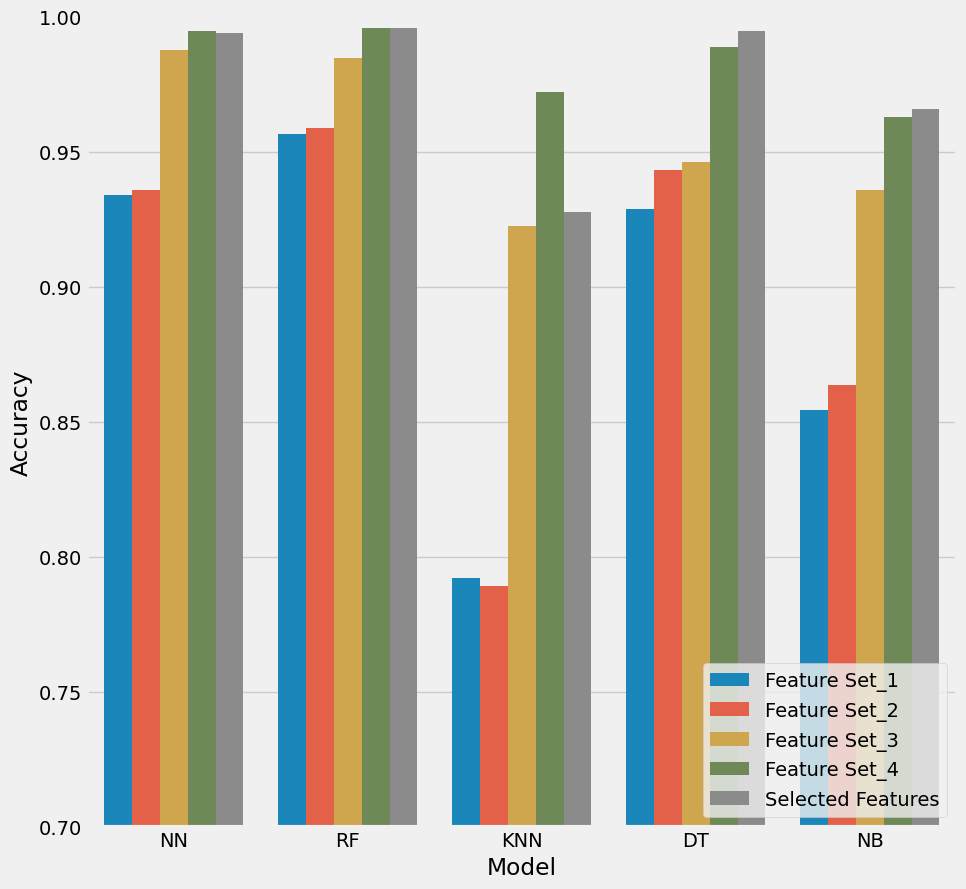

In [33]:
# --------------------------------------------------------------
# Create a grouped bar plot to compare the results
# --------------------------------------------------------------

print(score_df.sort_values(by="accuracy", ascending=False))

plt.figure(figsize=(10, 10))
sns.barplot(x="model", y="accuracy", hue="feature_set", data=score_df)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.legend(loc="lower right")
plt.show()

Accuracy 99.586


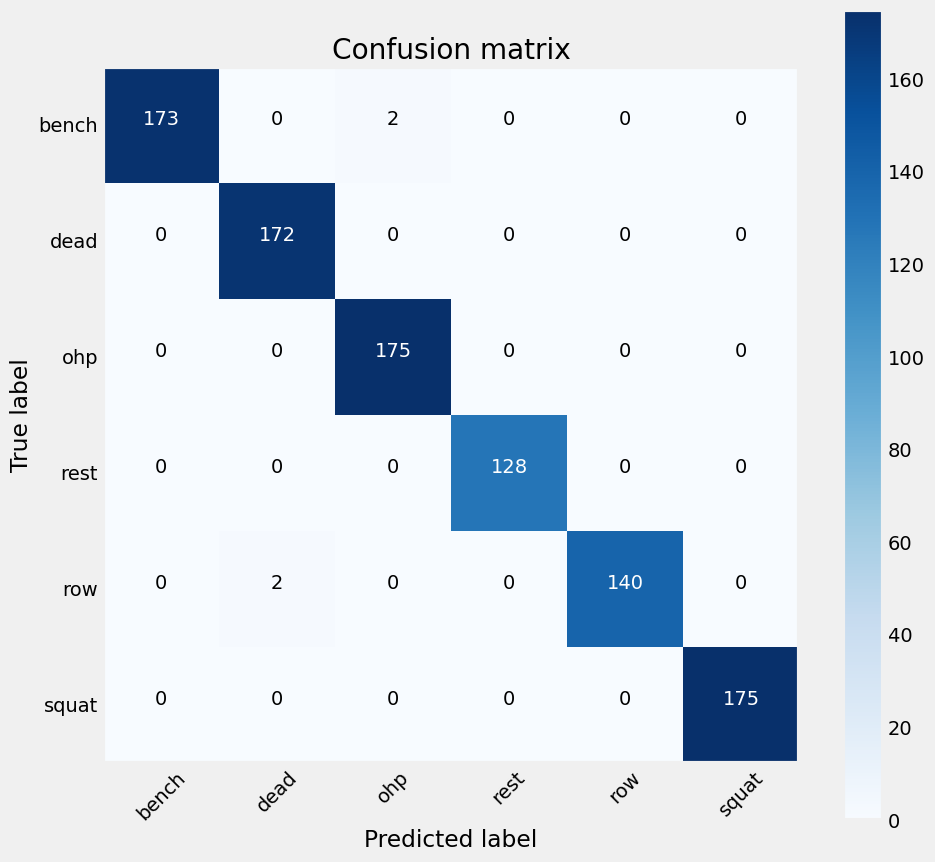

In [41]:
# --------------------------------------------------------------
# Select best model and evaluate results
# --------------------------------------------------------------

(
  class_train_y,
  class_test_y,
  class_train_prob_y,
  class_test_prob_y,
) = learner.random_forest(
  X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)

accuracy = accuracy_score(y_test, class_test_y)
print(f"Accuracy {round(accuracy * 100, 3)}")

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# Create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

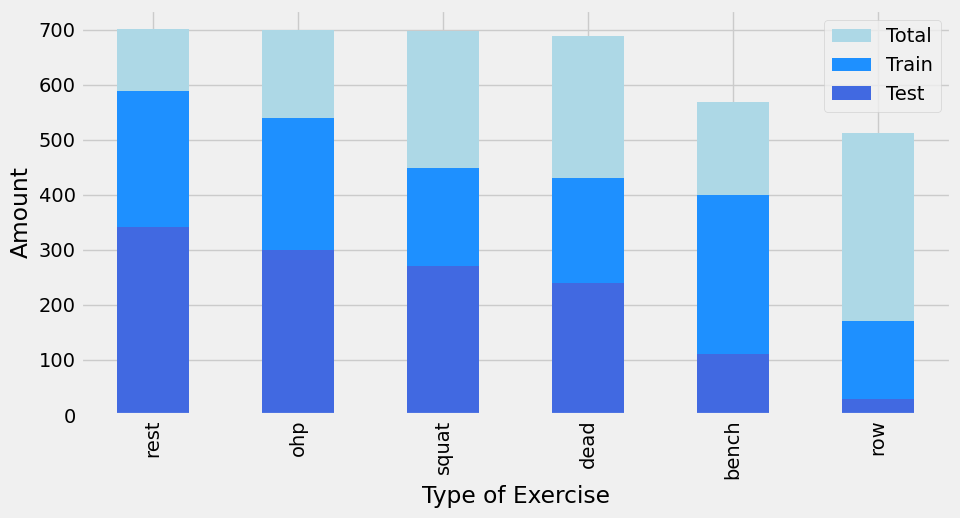

In [47]:
# --------------------------------------------------------------
# Select train and test data based on participant
# --------------------------------------------------------------

participant_df = df.drop(["set", "category"], axis=1)

# Data with all Participants without A
X_train = participant_df[participant_df["participant"] != "A"].drop("label", axis=1)
y_train = participant_df[participant_df["participant"] != "A"]["label"]

# Data with only Participant A
X_test = participant_df[participant_df["participant"] == "A"].drop("label", axis=1)
y_test = participant_df[participant_df["participant"] == "A"]["label"]

# Data with all Participants without A
X_train = X_train.drop(["participant"], axis=1)
X_test = X_test.drop(["participant"], axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().plot(kind="bar", ax=ax, color="lightblue", label="Total")
y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.xlabel("Type of Exercise")
plt.ylabel("Amount")
plt.legend()
plt.show()

Accuracy 99.613


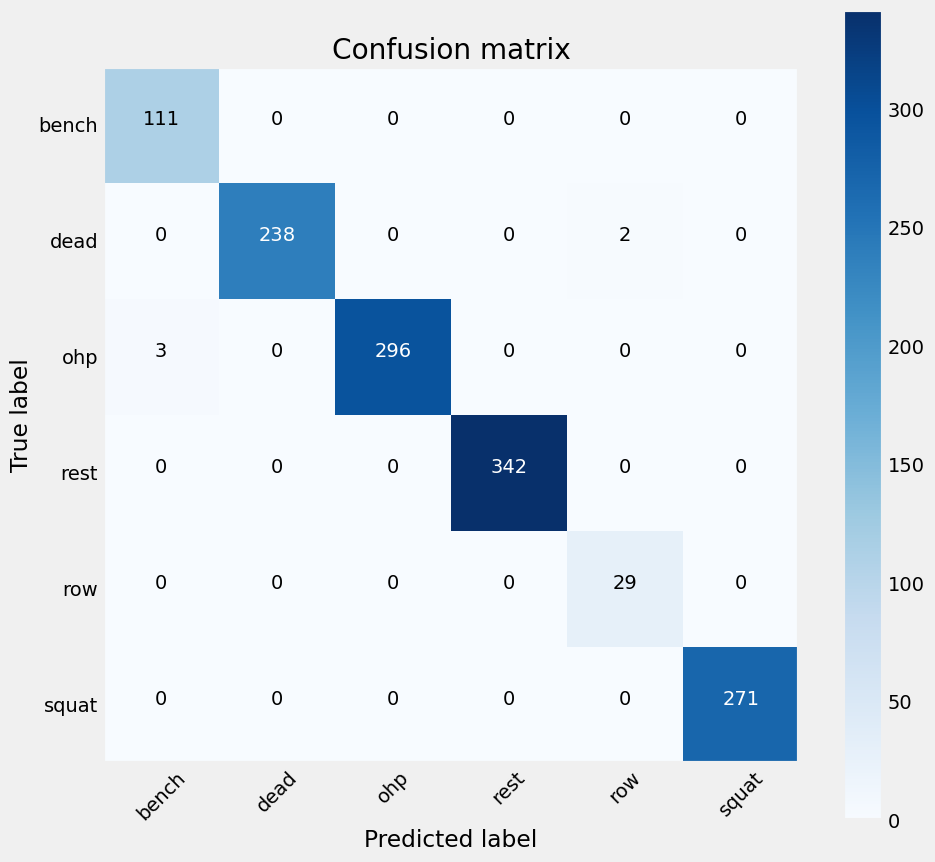

In [49]:
# --------------------------------------------------------------
# Use best model again and evaluate results
# --------------------------------------------------------------

(
  class_train_y,
  class_test_y,
  class_train_prob_y,
  class_test_prob_y,
) = learner.random_forest(
  X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)

accuracy = accuracy_score(y_test, class_test_y)
print(f"Accuracy {round(accuracy * 100, 3)}")

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# Create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

Accuracy 99.536


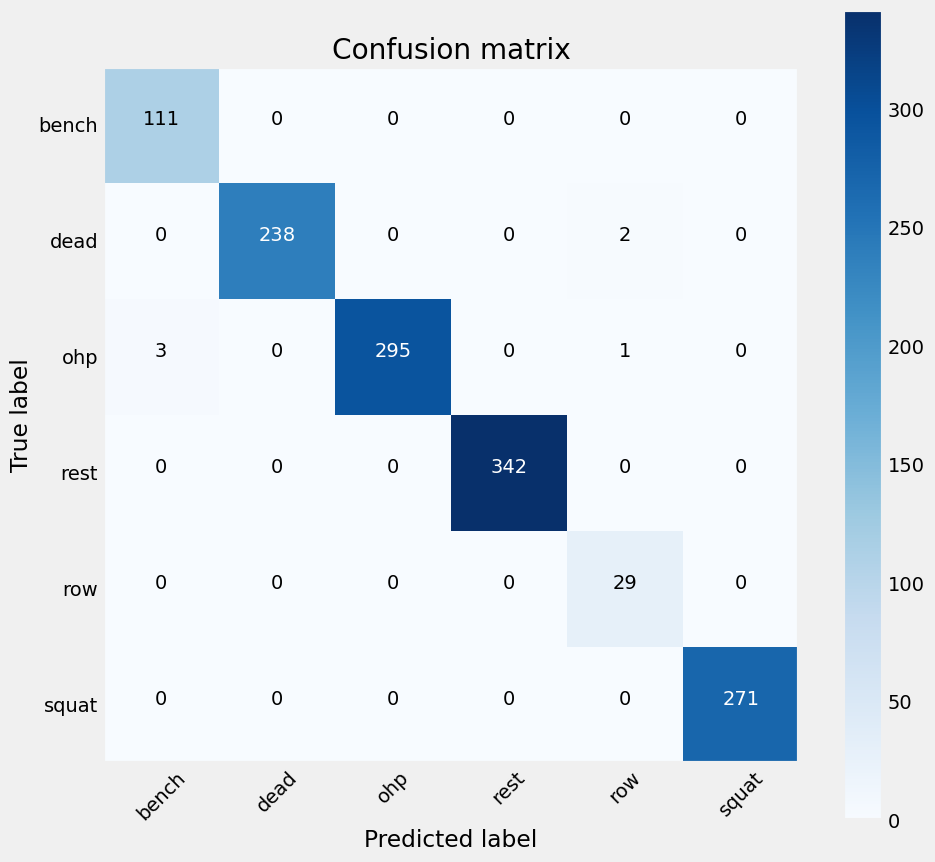

In [51]:
# --------------------------------------------------------------
# Try a complex model with the selected features
# --------------------------------------------------------------

(
  class_train_y,
  class_test_y,
  class_train_prob_y,
  class_test_prob_y,
) = learner.feedforward_neural_network(
  X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=False
)

accuracy = accuracy_score(y_test, class_test_y)
print(f"Accuracy {round(accuracy * 100, 3)}")

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# Create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()